In [ ]:
import numpy as np
import pandas as pd
import zipfile
import gc
import seaborn as sns
import matplotlib.pyplot as plt
gc.enable()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path="/content/drive/MyDrive/Data_btp2/"
train=zipfile.ZipFile(path+"data_train"+".zip","r")
test=zipfile.ZipFile(path+"data_test"+".zip","r")

In [ ]:
data_train = pd.read_csv(train.open('data_train.csv'))
data_test = pd.read_csv(test.open('data_test.csv'))

In [ ]:
X = data_train.drop(['reordered', 'uxp_ratio_last_five'], axis=1)
y = data_train.reordered

In [ ]:
pip install scikit-plot

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold,RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from scikitplot.metrics import plot_confusion_matrix
from scikitplot.classifiers import plot_feature_importances
from sklearn import metrics
from tqdm import tqdm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
pip install catboost

     |████████████████████████████████| 65.7MB 97kB/s 


In [ ]:
from catboost import CatBoostClassifier
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [ ]:
#For learning Rate and iterations
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1.0]
iterations = [100 , 300 , 600 , 1000]
prec_recall_area = []
dict_of_values = {}

#Loop for the Tuning
for lr in learning_rate:
    for ite in iterations:
        clf = CatBoostClassifier(
        iterations = ite,
        learning_rate=lr,
        verbose=False,
        )

        clf.fit(X_train, list(map(int , y_train)))

        y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
        prec_recall_area.append(np.trapz(recall,precision))
        print("With lr:",lr,",with iter:",ite , ",area is:" ,np.trapz(recall,precision))


In [ ]:
#for bagging temperature
temperature = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#Loop for the tuning
for temp in temperature:
    clf = CatBoostClassifier(
        iterations = 500, 
        depth = 14, #From above and did some iterations
        learning_rate=0.01,
        bagging_temperature = temp,
        verbose = False)

    clf.fit(X_train, list(map(int , y_train)))

    y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
    prec_recall_area.append(np.trapz(recall,precision))
    print("With temp:",temp , ",area is:" ,np.trapz(recall,precision))

In [ ]:
#Taking the best one.
#lr = 0.01,iter : 500 , depth: 14 , bagging_temperature : 0.1
clf = CatBoostClassifier(
    iterations = 1000, 
    random_strength = 0.5,
    depth = 14,
    learning_rate=0.01,
    bagging_temperature = 0.1,
    verbose = 3,
    task_type = "GPU",
)

#Mapping y into int format---- [0.0 , 1.0]---> [0,1] (Essential for catboost classifier)
clf.fit(X_train, list(map(int , y_train)))


0:	learn: 0.6805229	total: 295ms	remaining: 4m 54s
3:	learn: 0.6448553	total: 1.15s	remaining: 4m 47s
6:	learn: 0.6124325	total: 2.02s	remaining: 4m 46s
9:	learn: 0.5826793	total: 2.8s	remaining: 4m 36s
12:	learn: 0.5553683	total: 3.67s	remaining: 4m 38s
15:	learn: 0.5302699	total: 4.54s	remaining: 4m 39s
18:	learn: 0.5075020	total: 5.42s	remaining: 4m 39s
21:	learn: 0.4868043	total: 6.3s	remaining: 4m 40s
24:	learn: 0.4680041	total: 7.19s	remaining: 4m 40s
27:	learn: 0.4506042	total: 8.08s	remaining: 4m 40s
30:	learn: 0.4347533	total: 8.87s	remaining: 4m 37s
33:	learn: 0.4202386	total: 9.75s	remaining: 4m 37s
36:	learn: 0.4070259	total: 10.4s	remaining: 4m 31s
39:	learn: 0.3949060	total: 11.3s	remaining: 4m 31s
42:	learn: 0.3836915	total: 12.2s	remaining: 4m 31s
45:	learn: 0.3735918	total: 13.1s	remaining: 4m 31s
48:	learn: 0.3642758	total: 14s	remaining: 4m 30s
51:	learn: 0.3556447	total: 14.8s	remaining: 4m 30s
54:	learn: 0.3477902	total: 15.7s	remaining: 4m 29s
57:	learn: 0.3405294

In [ ]:
thresholds = clf.predict_proba(X_test)[:, 1]
f1_scores = []
values = np.arange(np.mean(thresholds)-(2*np.std(thresholds)) , np.mean(thresholds) +(2*np.std(thresholds))  , 0.02)
for value in tqdm(values):
    y_pred = (clf.predict_proba(X_test)[:, 1] >= value).astype('int')
    f1_scores.append(metrics.f1_score(y_test , y_pred))

100%|██████████| 27/27 [07:12<00:00, 16.00s/it]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


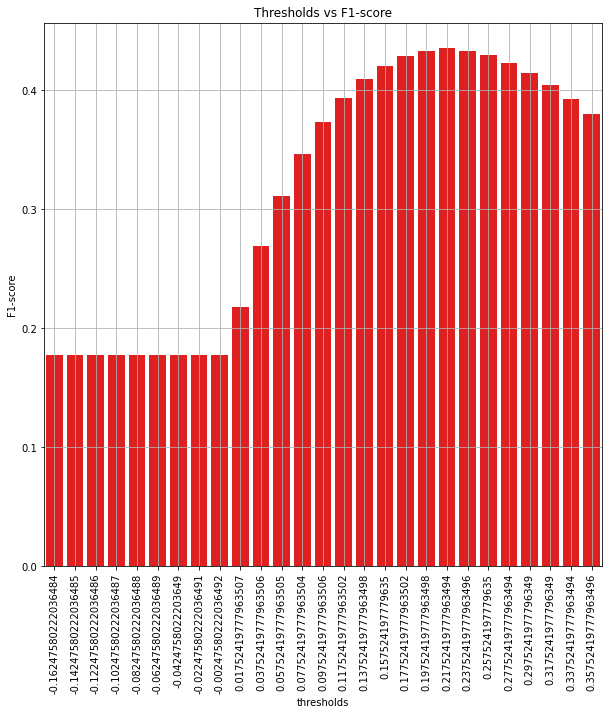

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(values , f1_scores , color = "red")
plt.xlabel("thresholds")
plt.ylabel("F1-score")
plt.title("Thresholds vs F1-score")
plt.grid(True)
plt.xticks(rotation = 90)

plt.show()

Confusion Matrix for Test-


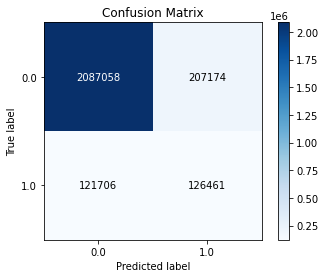

In [ ]:
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
#y_pred
print("Confusion Matrix for Test-")
plot_confusion_matrix(y_test,y_pred)

In [ ]:
y_train_pred =(clf.predict_proba(X_train)[:, 1] >= 0.21).astype('int')
print("Training F1 Score:", metrics.f1_score(y_train , y_train_pred))
print("Test F1 Score:",metrics.f1_score(y_test , y_pred))

Training F1 Score: 0.4511014708373535
Test F1 Score: 0.4347217781994562


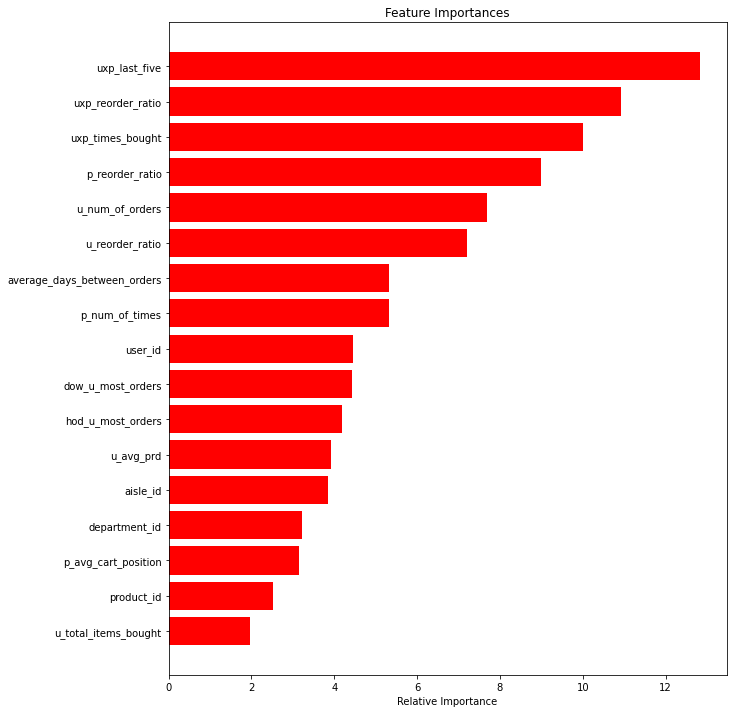

In [ ]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Entire Data
clf.fit(data_train.drop(['reordered', 'uxp_ratio_last_five'], axis=1), data_train.reordered)

0:	learn: 0.6805344	total: 341ms	remaining: 5m 40s
3:	learn: 0.6448192	total: 1.27s	remaining: 5m 16s
6:	learn: 0.6123061	total: 2.2s	remaining: 5m 11s
9:	learn: 0.5825188	total: 3.04s	remaining: 5m 1s
12:	learn: 0.5552107	total: 3.98s	remaining: 5m 2s
15:	learn: 0.5302147	total: 4.94s	remaining: 5m 3s
18:	learn: 0.5073579	total: 5.91s	remaining: 5m 5s
21:	learn: 0.4865786	total: 6.87s	remaining: 5m 5s
24:	learn: 0.4677570	total: 7.83s	remaining: 5m 5s
27:	learn: 0.4503520	total: 8.79s	remaining: 5m 5s
30:	learn: 0.4344998	total: 9.65s	remaining: 5m 1s
33:	learn: 0.4198920	total: 10.6s	remaining: 5m 1s
36:	learn: 0.4067062	total: 11.4s	remaining: 4m 56s
39:	learn: 0.3946271	total: 12.3s	remaining: 4m 56s
42:	learn: 0.3834986	total: 13.3s	remaining: 4m 56s
45:	learn: 0.3733513	total: 14.3s	remaining: 4m 55s
48:	learn: 0.3640588	total: 15.2s	remaining: 4m 54s
51:	learn: 0.3554690	total: 16.1s	remaining: 4m 53s
54:	learn: 0.3475949	total: 17.1s	remaining: 4m 52s
57:	learn: 0.3403903	total

In [ ]:
import pickle
filename = 'Catboost_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
y_pred_test = (clf.predict_proba(data_test.drop('uxp_ratio_last_five', axis=1))[:, 1] >= 0.21).astype('int')

In [ ]:
data_test['prediction'] = y_pred_test
data_test.head()

,user_id,product_id,uxp_times_bought,uxp_reorder_ratio,uxp_last_five,uxp_ratio_last_five,u_num_of_orders,u_avg_prd,dow_u_most_orders,hod_u_most_orders,u_reorder_ratio,average_days_between_orders,u_total_items_bought,p_num_of_times,p_reorder_ratio,p_avg_cart_position,aisle_id,department_id,prediction
0,3,248,1,0.090909,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,6371,0.400251,10.620782,0.070016,0.088504,0
1,3,1005,1,0.333333,1.0,0.2,12,7.333333,0,16,0.625,13.590909,88,463,0.440605,9.498920,0.066098,0.126562,0
2,3,1819,3,0.333333,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,2424,0.492162,9.287541,0.063782,0.037791,0
3,3,7503,1,0.100000,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,12474,0.553551,9.547379,0.070016,0.088504,0
4,3,8021,1,0.090909,0.0,0.0,12,7.333333,0,16,0.625,13.590909,88,27864,0.591157,8.822854,0.095193,0.054678,0


In [ ]:
final = data_test.reset_index()
final = final[['product_id', 'user_id', 'prediction']]

gc.collect()
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [ ]:
final.to_csv("final.csv",index=False)

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4833292 entries, 0 to 4833291
Data columns (total 3 columns):
 #   Column      Dtype
---  ------      -----
 0   product_id  int64
 1   user_id     int64
 2   prediction  int64
dtypes: int64(3)
memory usage: 110.6 MB


In [ ]:
orders=zipfile.ZipFile(path+"orders"+".zip","r")
orders = pd.read_csv(orders.open('orders.csv'))

In [ ]:
orders_test = orders.loc[orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [ ]:
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [ ]:
final = final.drop('user_id', axis=1)

In [ ]:
final['product_id'] = final.product_id.astype(int)

del orders
del orders_test
gc.collect()

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [ ]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

100

In [ ]:
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,17668 18599 21903 39190 43961 47766
1,1528013,21903 38293
2,1376945,8309 13176 14947 27959 28465 33572 34658 35948...
3,1356845,7076 10863 11520 13176 14992 22959
4,2161313,196 10441 11266 12427 14715 27839 37710


In [ ]:
sub.to_csv('sub.csv', index=False, header=True)

In [2]:
from PIL import Image

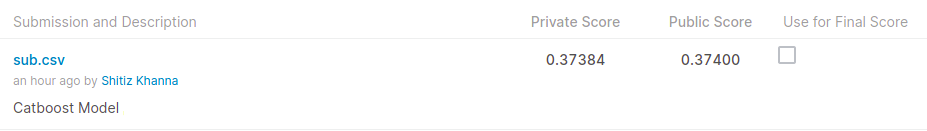

In [5]:
img=Image.open("../Submissions/catboost.png")
img